The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_temp/convergence_analysis_s1/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


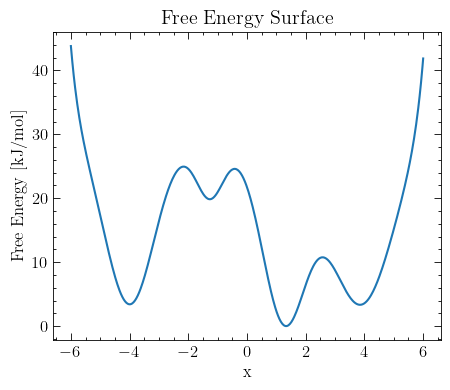

In [116]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis_s1/"): print("\nThe data folder \"_data_temp/convergence_analysis_s1/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis_s1/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis_s1/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 1
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

#### Define default parameters

In [12]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [75]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, #"dy":dy, # "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 1_000_000, 
					"position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":1, "biasfactor":10 , 
         			"Bias_sf":1, "gaus_filter_sigma":None, 
                    "len_error_list":100, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, "save_error_progression":True,
     				"simulation_folder_path": path_data, "print_info": False}

### Run Long simulation for reference

In [70]:
# Run 100 long simulations
long_sim_params = {**default_params}

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,38):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class1D.MFI1D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]
                
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, (AAD at 10% = {aad[10]:.4f})")
    if i_sim % 5 == 0: 
        aad_avr = np.mean(aad_collection, axis=0)
        print(f"--- Mean of final AAD: {aad_avr[-1]:.4f}, (10% = {aad_avr[10]:.4f})")       



Simulation 1 (exists) | Final Error: Aofe = 2.4584, AAD = 0.4012, (AAD at 10% = 0.7224)
Simulation 2 (exists) | Final Error: Aofe = 2.1197, AAD = 0.4982, (AAD at 10% = 0.8734)
Simulation 3 (exists) | Final Error: Aofe = 2.5598, AAD = 0.4231, (AAD at 10% = 0.9143)
Simulation 4 (exists) | Final Error: Aofe = 2.0800, AAD = 0.3361, (AAD at 10% = 0.5951)
Simulation 5 (exists) | Final Error: Aofe = 2.1946, AAD = 0.3585, (AAD at 10% = 0.3781)
--- Mean of final AAD: 0.4034, (10% = 0.6967)
Simulation 6 (exists) | Final Error: Aofe = 2.4284, AAD = 0.3633, (AAD at 10% = 0.7540)
Simulation 7 (exists) | Final Error: Aofe = 2.4328, AAD = 0.4509, (AAD at 10% = 0.6850)
Simulation 8 (exists) | Final Error: Aofe = 2.3743, AAD = 0.2733, (AAD at 10% = 0.4926)
Simulation 9 (exists) | Final Error: Aofe = 2.2554, AAD = 0.3396, (AAD at 10% = 0.4803)
Simulation 10 (exists) | Final Error: Aofe = 2.0073, AAD = 0.3090, (AAD at 10% = 1.0424)
--- Mean of final AAD: 0.3753, (10% = 0.6938)
Simulation 11 (exists) | Fi

Mean Final AAD: 0.3849 +- 0.0141


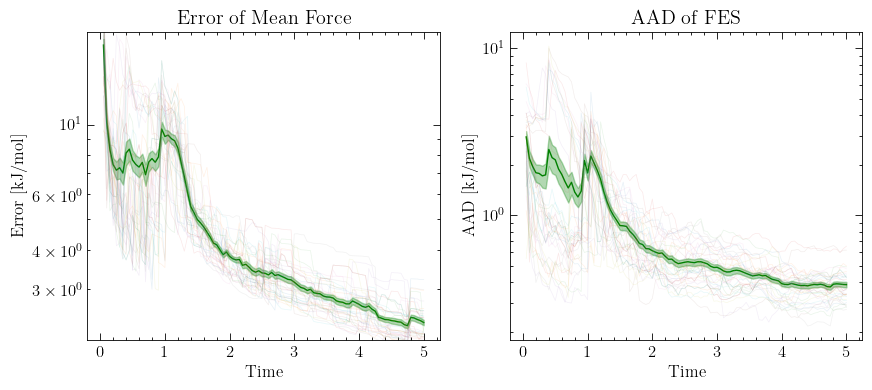

In [71]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f}")
plt.show()


### Exploration simulation

In [72]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":50_000, "metad_height":3, "metad_width":0.2, "biasfactor":100, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class1D.MFI1D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")       


Simulation 1 (exists) | Final Error: Aofe = 7.0044, AAD = 1.7384
Simulation 2 (exists) | Final Error: Aofe = 6.3593, AAD = 2.1437
Simulation 3 (exists) | Final Error: Aofe = 8.0621, AAD = 1.0967
Simulation 4 (exists) | Final Error: Aofe = 6.3907, AAD = 2.4486
Simulation 5 (exists) | Final Error: Aofe = 6.6719, AAD = 1.3283
--- Mean of final AAD: 1.7511
Simulation 6 (exists) | Final Error: Aofe = 6.2553, AAD = 1.4344
Simulation 7 (exists) | Final Error: Aofe = 7.5575, AAD = 2.1274
Simulation 8 (exists) | Final Error: Aofe = 7.3848, AAD = 2.3250
Simulation 9 (exists) | Final Error: Aofe = 6.3491, AAD = 1.2730
Simulation 10 (exists) | Final Error: Aofe = 6.5182, AAD = 1.2846
--- Mean of final AAD: 1.7200
Simulation 11 (exists) | Final Error: Aofe = 6.5256, AAD = 1.5414
Simulation 12 (exists) | Final Error: Aofe = 6.2353, AAD = 1.3536
Simulation 13 (exists) | Final Error: Aofe = 6.5202, AAD = 1.3580
Simulation 14 (exists) | Final Error: Aofe = 6.7060, AAD = 2.3740
Simulation 15 (exists) | 

Mean Final AAD: 1.7525 +- 0.0471


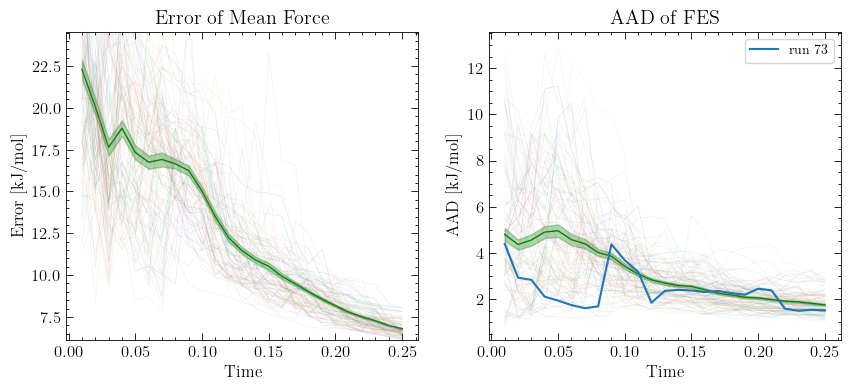

In [73]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

plt.plot(t, aad_collection[37-1], label="run 73")
plt.legend(fontsize=10)
plt.show()


In [67]:
# # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.5)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}", alpha=0.5)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

Final Error: Aofe = 6.7119, AAD = 1.7292
MIN(FES+Bias) = 27.3742, MIN(Z+Bias) = 33.4008


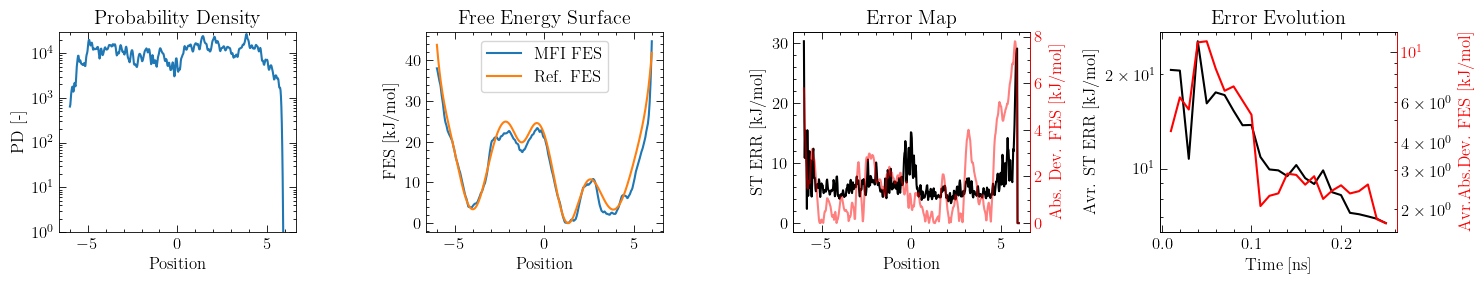

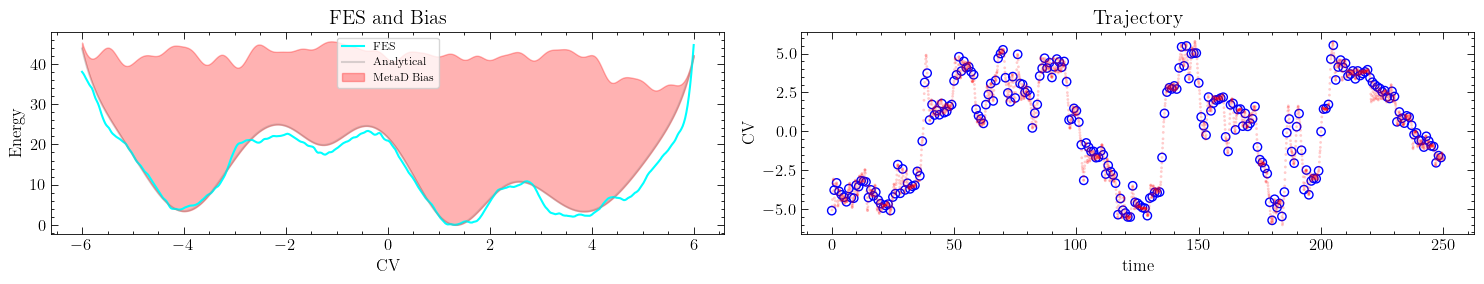

In [74]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
# new_params.update({"ID":"_expl_test", "len_error_list":25})
# new_params.update({"simulation_steps": 50_000, "metad_height":3, "metad_width":0.2, "biasfactor":100})
new_params.update({"save_error_progression":False, "save_force_terms":False})
new_params.update({"ID":"_expl_86", "len_error_list":25})

MFI_expl = MFI_class1D.MFI1D(**new_params)
# MFI_expl.run_simulation()
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(MFI_expl.y + MFI_expl.Bias):.4f}")
MFI_expl.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_expl.grid, fes=MFI_expl.FES, metad_bias=MFI_expl.Bias, position=MFI_expl.position, hills=MFI_expl.hills, y=MFI_expl.y )
t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES


### 2nd Stage - Run MetaD simulation

In [76]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":950_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): 
            MFI_metad.make_external_bias(FES=fes_expl)
            MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")


Simulation 1 | Final Error: Aofe = 1.3675, AAD = 0.2488
Simulation 2 | Final Error: Aofe = 1.3878, AAD = 0.2718
Simulation 3 | Final Error: Aofe = 1.3639, AAD = 0.1969
Simulation 4 | Final Error: Aofe = 1.3686, AAD = 0.4694
Simulation 5 | Final Error: Aofe = 1.3655, AAD = 0.3269
--- Mean of final AAD: 0.3027
Simulation 6 | Final Error: Aofe = 1.3685, AAD = 0.1875
Simulation 7 | Final Error: Aofe = 1.3928, AAD = 0.2166
Simulation 8 | Final Error: Aofe = 1.3723, AAD = 0.2891
Simulation 9 | Final Error: Aofe = 1.3782, AAD = 0.2717
Simulation 10 | Final Error: Aofe = 1.3834, AAD = 0.2202
--- Mean of final AAD: 0.2699
Simulation 11 | Final Error: Aofe = 1.3714, AAD = 0.2369
Simulation 12 | Final Error: Aofe = 1.3726, AAD = 0.2982
Simulation 13 | Final Error: Aofe = 1.3770, AAD = 0.2639
Simulation 14 | Final Error: Aofe = 1.3753, AAD = 0.2368
Simulation 15 | Final Error: Aofe = 1.3780, AAD = 0.2961
--- Mean of final AAD: 0.2687
Simulation 16 | Final Error: Aofe = 1.3830, AAD = 0.2523
Simulat

Mean Final AAD: 0.2648 +- 0.0059


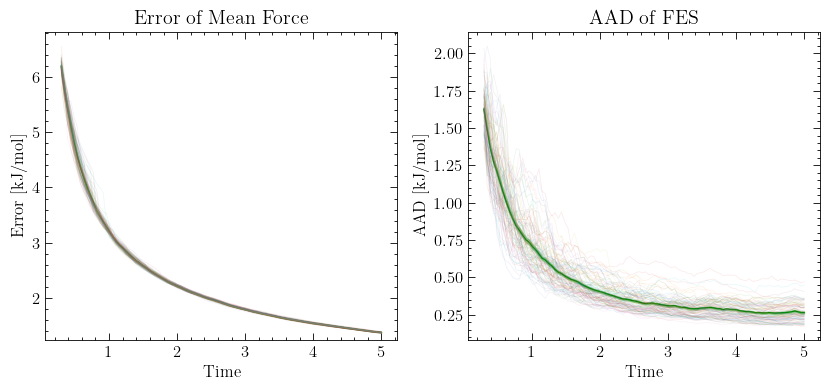

In [77]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f}")
plt.show()

### 2nd Stage - Run 2x MetaD simulations

In [78]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class1D.MFI1D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, aofe, aad = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.1440, AAD = 0.2408
Analysis 2 | Final Error: Aofe = 1.1341, AAD = 0.3385
Analysis 3 | Final Error: Aofe = 1.1313, AAD = 0.2275
Analysis 4 | Final Error: Aofe = 1.1432, AAD = 0.2365
Analysis 5 | Final Error: Aofe = 1.1433, AAD = 0.1931
Analysis 6 | Final Error: Aofe = 1.1406, AAD = 0.2080
Analysis 7 | Final Error: Aofe = 1.1462, AAD = 0.2422
Analysis 8 | Final Error: Aofe = 1.1450, AAD = 0.1834
Analysis 9 | Final Error: Aofe = 1.1429, AAD = 0.2186
Analysis 10 | Final Error: Aofe = 1.1382, AAD = 0.1992
Analysis 11 | Final Error: Aofe = 1.1343, AAD = 0.2070
Analysis 12 | Final Error: Aofe = 1.1315, AAD = 0.2130
Analysis 13 | Final Error: Aofe = 1.1397, AAD = 0.2261
Analysis 14 | Final Error: Aofe = 1.1379, AAD = 0.2307
Analysis 15 | Final Error: Aofe = 1.1352, AAD = 0.3683
Analysis 16 | Final Error: Aofe = 1.1375, AAD = 0.1712
Analysis 17 | Final Error: Aofe = 1.1325, AAD = 0.2255
Analysis 18 | Final Error: Aofe = 1.1412, AAD = 0.2226
Analysis 19 | Final

Mean Final AAD: 0.2323 +- 0.0062


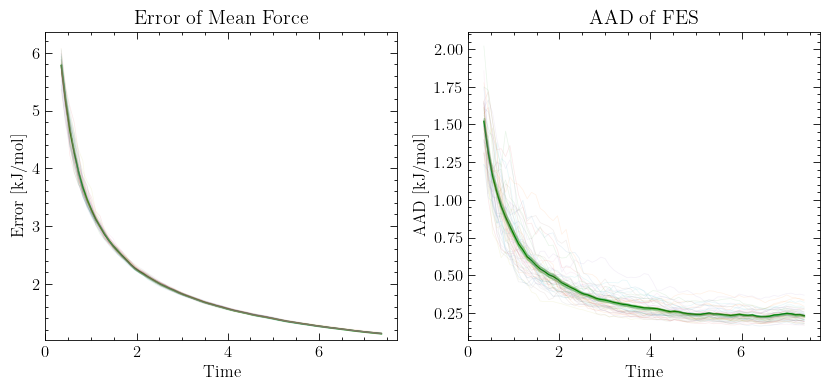

In [79]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - Run 3x MetaD simulations

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1);

In [80]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class1D.MFI1D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.9994, AAD = 0.2093
Analysis 2 | Final Error: Aofe = 0.9942, AAD = 0.2596
Analysis 3 | Final Error: Aofe = 0.9987, AAD = 0.1532
Analysis 4 | Final Error: Aofe = 1.0018, AAD = 0.1801
Analysis 5 | Final Error: Aofe = 1.0040, AAD = 0.2253
Analysis 6 | Final Error: Aofe = 1.0033, AAD = 0.1706
Analysis 7 | Final Error: Aofe = 0.9957, AAD = 0.1796
Analysis 8 | Final Error: Aofe = 0.9946, AAD = 0.1771
Analysis 9 | Final Error: Aofe = 0.9968, AAD = 0.2311
Analysis 10 | Final Error: Aofe = 0.9989, AAD = 0.2656
Analysis 11 | Final Error: Aofe = 0.9979, AAD = 0.1656
Analysis 12 | Final Error: Aofe = 0.9956, AAD = 0.2041
Analysis 13 | Final Error: Aofe = 1.0011, AAD = 0.2116
Analysis 14 | Final Error: Aofe = 0.9973, AAD = 0.2693
Analysis 15 | Final Error: Aofe = 1.0044, AAD = 0.2395
Analysis 16 | Final Error: Aofe = 1.0001, AAD = 0.2103
Analysis 17 | Final Error: Aofe = 1.0023, AAD = 0.2165
Analysis 18 | Final Error: Aofe = 0.9974, AAD = 0.2278
Analysis 19 | Final

Mean Final AAD: 0.2045 +- 0.0058


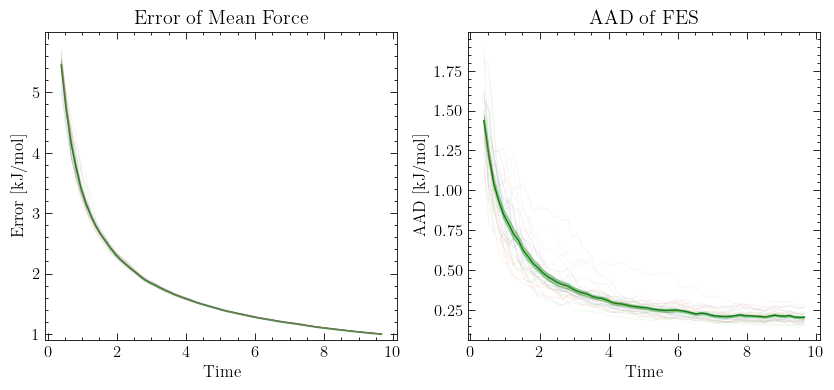

In [81]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - Run 4x MetaD simulations

In [82]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class1D.MFI1D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 | Final Error: Aofe = 1.0035, AAD = 0.2636
Analysis 2 | Final Error: Aofe = 1.0006, AAD = 0.1957
Analysis 3 | Final Error: Aofe = 1.0072, AAD = 0.1465
Analysis 4 | Final Error: Aofe = 1.0103, AAD = 0.2145
Analysis 5 | Final Error: Aofe = 1.0069, AAD = 0.1527
Analysis 6 | Final Error: Aofe = 1.0008, AAD = 0.1796
Analysis 7 | Final Error: Aofe = 1.0009, AAD = 0.1889
Analysis 8 | Final Error: Aofe = 0.9971, AAD = 0.2136
Analysis 9 | Final Error: Aofe = 1.0039, AAD = 0.2127
Analysis 10 | Final Error: Aofe = 1.0038, AAD = 0.2363
Analysis 11 | Final Error: Aofe = 1.0020, AAD = 0.2546
Analysis 12 | Final Error: Aofe = 1.0028, AAD = 0.2037
Analysis 13 | Final Error: Aofe = 1.0076, AAD = 0.2474
Analysis 14 | Final Error: Aofe = 1.0002, AAD = 0.2479
Analysis 15 | Final Error: Aofe = 0.9965, AAD = 0.1635
Analysis 16 | Final Error: Aofe = 0.9988, AAD = 0.1871
Analysis 17 | Final Error: Aofe = 1.0036, AAD = 0.1593
Analysis 18 | Final Error: Aofe = 1.0046, AAD = 0.1678
Analysis 19 | Final

Mean Final AAD: 0.1972 +- 0.0069


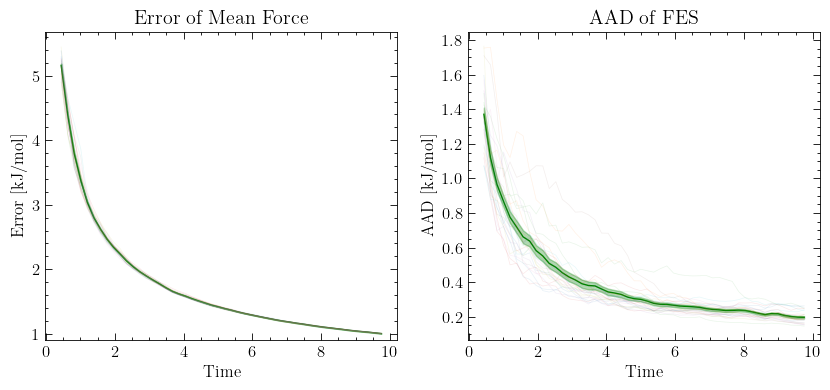

In [83]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [84]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class1D.MFI1D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.9165, AAD = 0.2234
Analysis 2 | Final Error: Aofe = 0.9271, AAD = 0.1719
Analysis 3 | Final Error: Aofe = 0.9267, AAD = 0.2108
Analysis 4 | Final Error: Aofe = 0.9164, AAD = 0.2050
Analysis 5 | Final Error: Aofe = 0.9170, AAD = 0.2486
Analysis 6 | Final Error: Aofe = 0.9170, AAD = 0.2327
Analysis 7 | Final Error: Aofe = 0.9155, AAD = 0.2688
Analysis 8 | Final Error: Aofe = 0.9210, AAD = 0.2490
Analysis 9 | Final Error: Aofe = 0.9212, AAD = 0.1814
Analysis 10 | Final Error: Aofe = 0.9134, AAD = 0.1911
Analysis 11 | Final Error: Aofe = 0.9152, AAD = 0.2025
Analysis 12 | Final Error: Aofe = 0.9207, AAD = 0.2063
Analysis 13 | Final Error: Aofe = 0.9172, AAD = 0.1794
Analysis 14 | Final Error: Aofe = 0.9223, AAD = 0.2215
Analysis 15 | Final Error: Aofe = 0.9158, AAD = 0.1947
Analysis 16 | Final Error: Aofe = 0.9211, AAD = 0.1849


Mean Final AAD: 0.2045 +- 0.0058


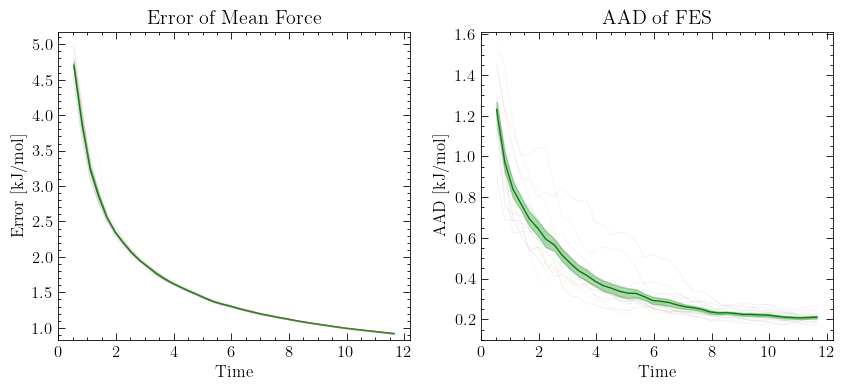

In [85]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [86]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class1D.MFI1D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.8354, AAD = 0.1915
Analysis 2 | Final Error: Aofe = 0.8313, AAD = 0.2219
Analysis 3 | Final Error: Aofe = 0.8261, AAD = 0.2143
Analysis 4 | Final Error: Aofe = 0.8264, AAD = 0.2498
Analysis 5 | Final Error: Aofe = 0.8334, AAD = 0.1900
Analysis 6 | Final Error: Aofe = 0.8265, AAD = 0.1874
Analysis 7 | Final Error: Aofe = 0.8327, AAD = 0.2116
Analysis 8 | Final Error: Aofe = 0.8287, AAD = 0.1787
Analysis 9 | Final Error: Aofe = 0.8287, AAD = 0.2106
Analysis 10 | Final Error: Aofe = 0.8305, AAD = 0.1771


Mean Final AAD: 0.2045 +- 0.0058


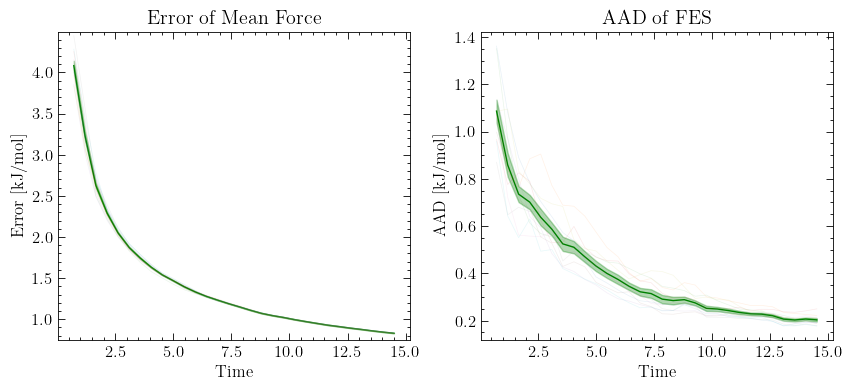

In [87]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [88]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = max(5, int(len(data)/20))    
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

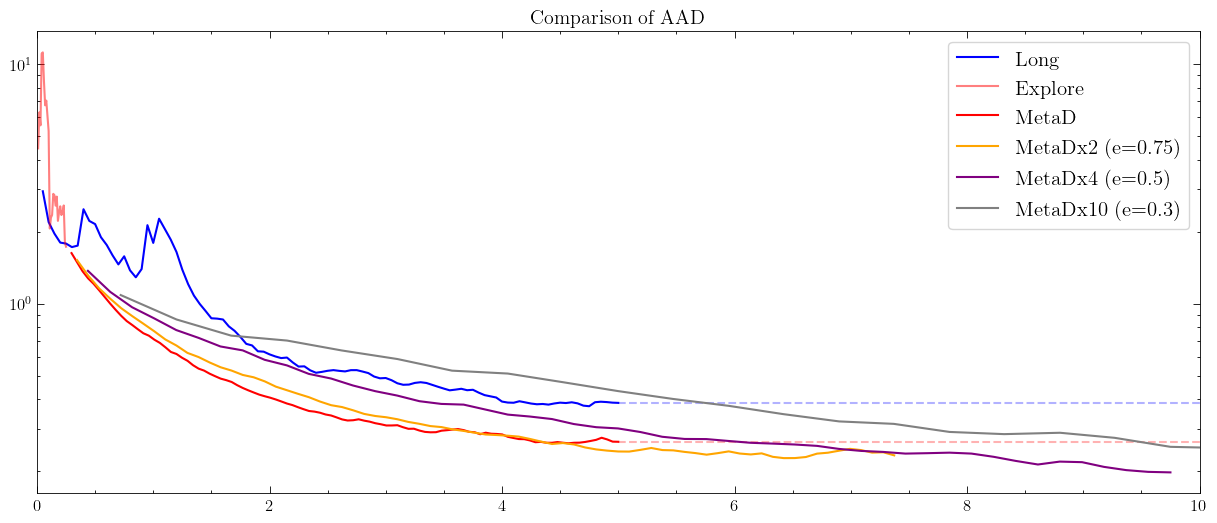

In [122]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(20,4))
# # time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

# plt.subplot(1,2,1)
# plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# # plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2 (e=0.75)", color="orange")
# # plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3(e=0.67)", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4 (e=0.5)", color="purple")
# # plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6 (e=0.4)", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx10 (e=0.3)", color="grey")
# plt.legend(fontsize=10); plt.yscale("log"); plt.title("Comparison of Aofe")

# plt.subplot(1,2,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1],10], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1],10], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2 (e=0.75)", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3 (e=0.67)", color="green")
plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4 (e=0.5)", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6 (e=0.4)", color="aquamarine")
plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx10 (e=0.3)", color="grey")

# plt.ylim(0.38, 3)
plt.xlim(0, 10)
plt.yscale("log"); 
plt.legend(fontsize=15); plt.title("Comparison of AAD"); plt.show()

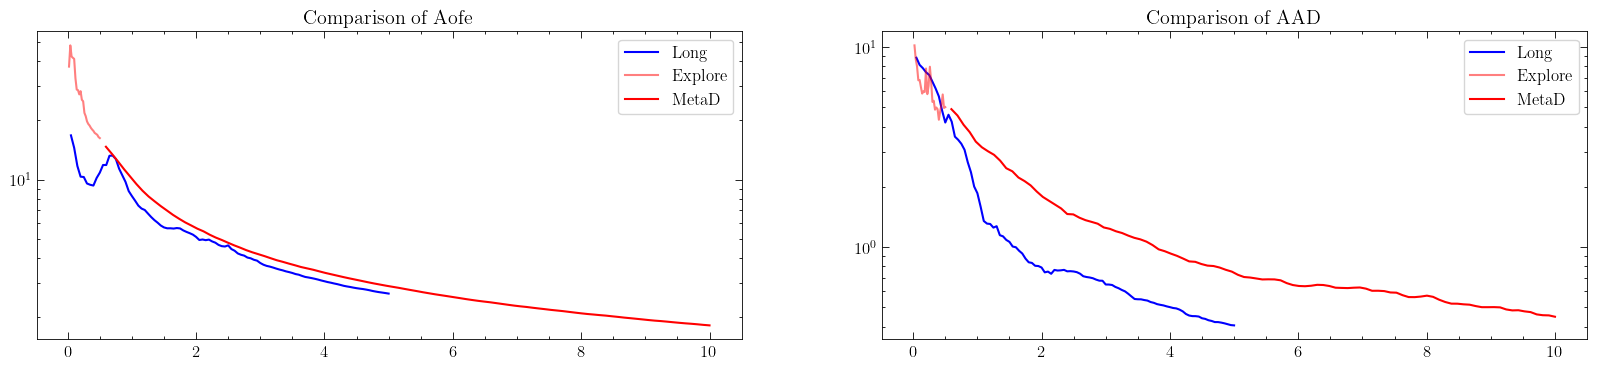

In [23]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, mean_aad_long, label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_aad_metad, label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, mean_aad_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_aad_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_aad_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_aad_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx6", color="grey")

# plt.ylim(0.38, 0.6)
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
